News Sentiment Analysis-In this project, we have identified the sentiments of heaadlines and title of the news present in the given dataset using NLP.


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from textblob import TextBlob
import nltk
import re
import datetime
import math
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVR
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud, STOPWORDS 

%matplotlib inline

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ SA/train_file.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ SA/test_file.csv')
test_id = test['IDLink']

In [ ]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [ ]:
test.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
0,tFrqIR6Chj,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,BusinessDay,economy,2016-03-29 01:41:12,0,0,1
1,DVAaGErjlF,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,Daily Mail,microsoft,2016-03-29 01:41:27,121,2,13
2,OT9UIZm5M2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,EURweb,microsoft,2016-03-29 01:47:00,12,1,0
3,lflGp3q2Fj,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,Bloomberg via Yahoo! Finance,economy,2016-03-29 02:00:00,0,0,3
4,zDYG0SoovZ,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",FXStreet,economy,2016-03-29 02:01:07,3,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55932 entries, 0 to 55931
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             55932 non-null  object 
 1   Title              55932 non-null  object 
 2   Headline           55932 non-null  object 
 3   Source             55757 non-null  object 
 4   Topic              55932 non-null  object 
 5   PublishDate        55932 non-null  object 
 6   Facebook           55932 non-null  int64  
 7   GooglePlus         55932 non-null  int64  
 8   LinkedIn           55932 non-null  int64  
 9   SentimentTitle     55932 non-null  float64
 10  SentimentHeadline  55932 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 4.7+ MB


In [ ]:
train.describe()

,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
count,55932.000000,55932.000000,55932.000000,55932.000000,55932.000000
mean,132.050329,4.551616,14.300132,-0.006318,-0.029577
std,722.931314,21.137177,76.651420,0.137569,0.143038
min,-1.000000,-1.000000,-1.000000,-0.838525,-0.755355
25%,0.000000,0.000000,0.000000,-0.079057,-0.116927
50%,6.000000,0.000000,0.000000,0.000000,-0.027277
75%,37.000000,2.000000,4.000000,0.063969,0.057354
max,49211.000000,1267.000000,3716.000000,0.962354,0.964646


In [ ]:
train.isnull().sum()

IDLink                 0
Title                  0
Headline               0
Source               175
Topic                  0
PublishDate            0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64

In [ ]:
test.isnull().sum()

IDLink           0
Title            0
Headline         0
Source         101
Topic            0
PublishDate      0
Facebook         0
GooglePlus       0
LinkedIn         0
dtype: int64

In [ ]:
train['Source'].value_counts()[:5]

Bloomberg         1167
Reuters            763
ABC News           645
New York Times     573
The Guardian       551
Name: Source, dtype: int64

In [ ]:
train['Source'] = train['Source'].fillna('Bloomberg')
test['Source'] = test['Source'].fillna('Bloomberg')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

def clean(text):
  text_token = word_tokenize(text)
  filtered_text = ' '.join([w.lower() for w in text_token if w.lower() not in stop and len(w) > 2])
  filtered_text = filtered_text.replace(r"[^a-zA-Z]+", '')
  text_only = re.sub(r'\b\d+\b', '', filtered_text)
  clean_text = text_only.replace(',', '').replace('.', '').replace(':', '')
  return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
train['Text_Title'] = train['Title'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Title'] = test['Title'] + ' ' + test['Source'] + ' ' + test['Topic']

train['Text_Headline'] = train['Headline'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Headline'] = test['Headline'] + ' ' + test['Source'] + ' ' + test['Topic']

In [ ]:
train['Text_Title'][4]

'Tourism, govt spending buoys Thai economy in January The Nation - Thailand&#39;s English news economy'

In [ ]:
train['Text_Title'].head()

0    Obama Lays Wreath at Arlington National Cemete...
1    A Look at the Health of the Chinese Economy Bl...
2    Nouriel Roubini: Global Economy Not Back to 20...
3           Finland GDP Expands In Q4 RTT News economy
4    Tourism, govt spending buoys Thai economy in J...
Name: Text_Title, dtype: object

In [ ]:
train['Text_Title'] = [clean(x) for x in train['Text_Title']]
test['Text_Title'] = [clean(x) for x in test['Text_Title']]

train['Text_Headline'] = [clean(x) for x in train['Text_Headline']]
test['Text_Headline'] = [clean(x) for x in test['Text_Headline']]

In [ ]:
train['Text_Title'].head()

0    obama lays wreath arlington national cemetery ...
1        look health chinese economy bloomberg economy
2    nouriel roubini global economy back  bloomberg...
3                 finland gdp expands rtt news economy
4    tourism govt spending buoys thai economy janua...
Name: Text_Title, dtype: object

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True)

train_v_Title = vectorizer.fit_transform(train['Text_Title'])
test_v_Title = vectorizer.transform(test['Text_Title'])

vectorizer_ = TfidfVectorizer()

train_v_Headline = vectorizer_.fit_transform(train['Text_Headline'])
test_v_Headline = vectorizer_.transform(test['Text_Headline'])

In [ ]:
count_tokens=vectorizer.get_feature_names()

In [ ]:
train_v_Title[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
df_tfidf_vect=pd.DataFrame(data=train_v_Title[9999].toarray(),columns=count_tokens)
df_tfidf_vect

,00pm,100b,100bln,100bn,100k,100m,100s,100th,102m,1080p,10b,10g,10th,10tv,110b,116m,11bn,11th,120bn,123m,123rd,125k,125m,128gb,12am,12b,12bn,12k,12newscom,12newsnowcom,131m,138th,13abc,13b,13billion,13m,13mn,13newsnowcom,13th,13wmaz,...,zim,zimbabwe,zimbabwean,zimbabwecom,zimeye,zimmerman,zing,zings,zinox,zion,zionaire,zionism,zionist,zionists,zionsville,zipcar,zloty,zogby,zolmax,zolv,zomato,zombie,zombies,zone,zones,zoning,zoo,zoom,zoomers,zoos,zuckerberg,zum,zuma,zumba,zunar,zune,zurbruegg,zvezda,zwane,zyoud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train['polarity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
train['polarity_t'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: polarity_t, dtype: float64

In [ ]:
train['polarity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
encoder = LabelEncoder()

train['Topic'] = encoder.fit_transform(train['Topic'])
test['Topic'] = encoder.transform(test['Topic'])

total = train['Source'].to_list() + test['Source'].to_list()
total = encoder.fit_transform(total)
train['Source'] = encoder.transform(train['Source'])
test['Source'] = encoder.transform(test['Source'])

In [ ]:
train['Topic'].head()

0    2
1    0
2    0
3    0
4    0
Name: Topic, dtype: int64

In [ ]:
train_weekday = []
test_weekday = []

for i in train['PublishDate']:
    train_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))
    
for i in test['PublishDate']:
    test_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))

train['weekday'] = train_weekday
test['weekday'] = test_weekday


# convert weekday to 0-6

train['weekday'] = train['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})
test['weekday'] = test['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})

In [ ]:
train['weekday']

0        1
1        5
2        5
3        6
4        6
        ..
55927    1
55928    1
55929    1
55930    1
55931    1
Name: weekday, Length: 55932, dtype: int64

In [ ]:
train["hour"] = train["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])
test["hour"] = test["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])

In [ ]:
train['hour']

0        00
1        00
2        00
3        00
4        00
         ..
55927    01
55928    01
55929    01
55930    01
55931    01
Name: hour, Length: 55932, dtype: object

Text(0, 0.5, 'SentimentTitle')

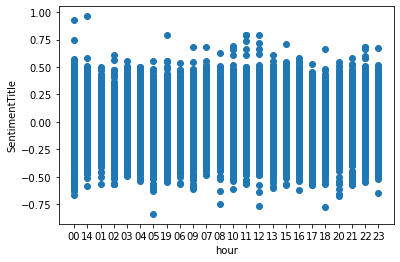

In [ ]:
plt.scatter(train['hour'], train['SentimentTitle'])
plt.xlabel('hour')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

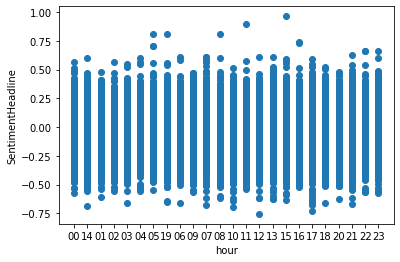

In [ ]:
# hour distribution of SentimentHeadline

plt.scatter(train['hour'], train['SentimentHeadline'])
plt.xlabel('hour')
plt.ylabel('SentimentHeadline')

Text(0, 0.5, 'SentimentTitle')

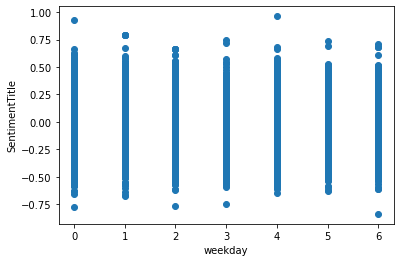

In [ ]:
# weekday distribution of SentimentTitle

plt.scatter(train['weekday'], train['SentimentTitle'])
plt.xlabel('weekday')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

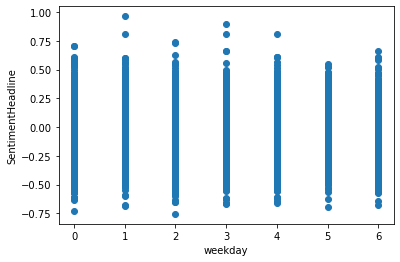

In [ ]:
# weekday distribution of SentimentHeadline

plt.scatter(train['weekday'], train['SentimentHeadline'])
plt.xlabel('weekday')
plt.ylabel('SentimentHeadline')

In [ ]:
# Number of words in the Title 
train["num_words_t"] = train["Text_Title"].apply(lambda x: len(str(x).split()))
test["num_words_t"] = test["Text_Title"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Title 
train["num_unique_words_t"] = train["Text_Title"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_t"] = test["Text_Title"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Title 
train["num_chars_t"] = train["Text_Title"].apply(lambda x: len(str(x)))
test["num_chars_t"] = test["Text_Title"].apply(lambda x: len(str(x)))

# Average length of the words in the Title 
train["mean_word_len_t"] = train["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_t"] = test["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
train["num_words_t"]

0         9
1         6
2         7
3         6
4        12
         ..
55927    10
55928     9
55929    10
55930     7
55931     6
Name: num_words_t, Length: 55932, dtype: int64

In [ ]:
train["num_unique_words_t"]

0         8
1         5
2         6
3         6
4        11
         ..
55927     9
55928     8
55929     9
55930     6
55931     5
Name: num_unique_words_t, Length: 55932, dtype: int64

In [ ]:
train["mean_word_len_t"]

0        5.888889
1        6.666667
2        6.714286
3        5.166667
4        6.166667
           ...   
55927    5.300000
55928    5.888889
55929    5.400000
55930    7.428571
55931    6.666667
Name: mean_word_len_t, Length: 55932, dtype: float64

In [ ]:
# Number of words in the Headline 
train["num_words_h"] = train["Text_Headline"].apply(lambda x: len(str(x).split()))
test["num_words_h"] = test["Text_Headline"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Headline 
train["num_unique_words_h"] = train["Text_Headline"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_h"] = test["Text_Headline"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Headline 
train["num_chars_h"] = train["Text_Headline"].apply(lambda x: len(str(x)))
test["num_chars_h"] = test["Text_Headline"].apply(lambda x: len(str(x)))

# Average length of the words in the Headline 
train["mean_word_len_h"] = train["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_h"] = test["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
scaler = StandardScaler()

cols = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t',
        'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'hour', 'weekday']

for col in cols:
  train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
  test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [ ]:
cols_t = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t', 'polarity_t', 'subjectivity_t', 'hour', 'weekday']
train_X1 = train[cols_t]
test_X1 = test[cols_t]

cols_h = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'polarity_h', 'subjectivity_h', 'hour', 'weekday']
train_X2 = train[cols_h]
test_X2 = test[cols_h]

In [ ]:
train_X1.head()

,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_t,num_unique_words_t,num_chars_t,mean_word_len_t,polarity_t,subjectivity_t,hour,weekday
0,1.257700,0.841443,-0.184044,-0.262649,-0.199608,-0.25916,-0.304674,-0.572741,-0.612986,0.0,0.0,-1.699073,-0.795924
1,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-1.66871,-1.721687,-1.629606,0.274360,0.0,0.0,-1.699073,1.338369
2,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-1.19886,-1.249349,-1.035120,0.328687,0.0,0.0,-1.699073,1.338369
3,0.468412,-1.108773,-0.184044,-0.262649,-0.199608,-1.66871,-1.249349,-2.224092,-1.436950,0.0,0.0,-1.699073,1.871942
4,1.029071,-1.108773,-0.184044,-0.262649,-0.199608,1.15039,1.112340,1.012556,-0.296077,0.0,0.0,-1.699073,1.871942


In [ ]:
train_X1.values

array([[ 1.25769976,  0.8414431 , -0.18404448, ...,  0.        ,
        -1.69907332, -0.79592395],
       [-1.31409102, -1.10877322, -0.18404448, ...,  0.        ,
        -1.69907332,  1.33836912],
       [-1.31409102, -1.10877322, -0.18404448, ...,  0.        ,
        -1.69907332,  1.33836912],
       ...,
       [-0.45701891,  0.8414431 , -0.04156771, ...,  0.66666667,
        -1.55539697, -0.79592395],
       [ 0.79239922, -0.13366506, -0.18266121, ...,  1.        ,
        -1.55539697, -0.79592395],
       [ 1.48001002, -1.10877322, -0.07891599, ...,  0.        ,
        -1.55539697, -0.79592395]])

In [ ]:
train_X2.head()

,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_h,num_unique_words_h,num_chars_h,mean_word_len_h,polarity_h,subjectivity_h,hour,weekday
0,1.257700,0.841443,-0.184044,-0.262649,-0.199608,-0.285960,-0.526779,-0.490565,-1.058634,0.000000,0.000000,-1.699073,-0.795924
1,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-0.285960,-0.232528,-0.317704,-0.175984,0.100000,0.200000,-1.699073,1.338369
2,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-0.413322,-0.673904,-0.300418,0.618402,0.000000,0.041667,-1.699073,1.338369
3,0.468412,-1.108773,-0.184044,-0.262649,-0.199608,0.096128,0.061723,0.304596,0.843478,-0.166667,0.166667,-1.699073,1.871942
4,1.029071,-1.108773,-0.184044,-0.262649,-0.199608,0.223490,0.208849,0.391026,0.618402,0.133333,0.380556,-1.699073,1.871942


In [ ]:
print(np.shape(train_X1))
print(np.shape(test_X1))

(55932, 13)
(37288, 13)


In [ ]:
print(np.shape(train_X2))
print(np.shape(test_X2))

(55932, 13)
(37288, 13)


In [ ]:
print(np.shape(train_v_Title))
print(np.shape(test_v_Title))

(55932, 25377)
(37288, 25377)


In [ ]:
print(np.shape(train_v_Headline))
print(np.shape(test_v_Headline))

(55932, 38787)
(37288, 38787)


In [ ]:
train_X_Title = hstack([train_v_Title, csr_matrix(train_X1.values)])
test_X_Title = hstack([test_v_Title, csr_matrix(test_X1.values)])
y1 = train['SentimentTitle']

train_X_Headline = hstack([train_v_Headline, csr_matrix(train_X2.values)])
test_X_Headline = hstack([test_v_Headline, csr_matrix(test_X2.values)])
y2 = train['SentimentHeadline']

In [ ]:
train_X_Title.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.69907332, -0.79592395],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.69907332,  1.33836912],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.69907332,  1.33836912],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.66666667,
        -1.55539697, -0.79592395],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -1.55539697, -0.79592395],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.55539697, -0.79592395]])

In [ ]:
np.shape(train_X_Title)

(55932, 25390)

In [ ]:
# LinearSVR model for SentimentTitle

X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)

print('MAE:', mae1)

MAE: 0.056673158447237


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# LinearSVR model for SentimentHeadline

X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.2)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)

print('MAE:',  mae2)

MAE: 0.07092543483783398


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
title = clf1.predict(test_X_Title)
headline = clf2.predict(test_X_Headline)

In [ ]:
df = pd.DataFrame()
df['IDLink'] = test_id
df['SentimentTitle'] = title
df['SentimentHeadline'] = headline
df.to_csv('/content/drive/MyDrive/Colab Notebooks/ SA/SUBMIT.csv', index=False)

In [ ]:
import pickle
# open a file, where you ant to store the data
file = open('LinearSVR_model.pkl', 'wb')

# dump information to that file
pickle.dump(clf2, file)